# Annualising Return and Risk (MSFT Example)

This notebook shows how to estimate daily and annualised investment reward/risk from daily stock prices using log returns.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.6f}'.format
plt.style.use('seaborn-v0_8-darkgrid')

## 1) Load Historical Daily Price Data

In [2]:
CSV_PATH = "msft.csv"

price_data = pd.read_csv(CSV_PATH)

if "Date" not in price_data.columns:
    raise ValueError("CSV must contain a 'Date' column.")

price_data["Date"] = pd.to_datetime(price_data["Date"], errors="coerce")
price_data = price_data.dropna(subset=["Date"]).sort_values("Date").set_index("Date")

if "Adj Close" in price_data.columns:
    price_column = "Adj Close"
elif "Close" in price_data.columns:
    price_column = "Close"
elif "MSFT" in price_data.columns:
    price_column = "MSFT"
else:
    raise ValueError("CSV must contain one of: 'Adj Close', 'Close', or 'MSFT'.")

price_series = pd.to_numeric(price_data[price_column], errors="coerce").dropna()

print(f"Using price column: {price_column}")
print(f"Date range: {price_series.index.min().date()} to {price_series.index.max().date()}")
print(f"Observations: {len(price_series)}")

price_series.head()

Using price column: MSFT
Date range: 2014-10-01 to 2021-05-28
Observations: 1677


Date
2014-10-01   38.880161
2014-10-02   38.761574
2014-10-03   39.041103
2014-10-06   39.041103
2014-10-07   38.566746
Name: MSFT, dtype: float64

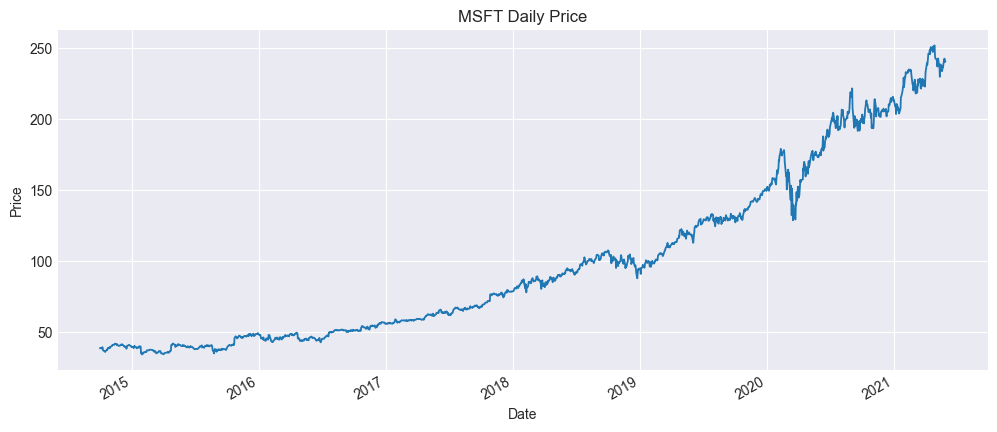

In [3]:
price_series.plot(figsize=(12, 5), title="MSFT Daily Price", linewidth=1.3)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

## 2) Compute Logarithmic Returns

Log return measures the continuously compounded percentage change from one day to the next:

`log_return_t = ln(P_t / P_{t-1})`

Where:
- `P_t` = price at day `t`
- `P_{t-1}` = price at the previous day
- `P_t / P_{t-1}` = gross return (growth factor)
- `ln(...)` converts that growth factor into a log return

Interpretation:
- If `P_t > P_{t-1}`, log return is positive.
- If `P_t < P_{t-1}`, log return is negative.
- For small daily moves, log returns are very close to simple returns, but log returns are easier to aggregate over time.

In [4]:
simple_returns = price_series.pct_change()
log_returns = np.log(price_series / price_series.shift(1))
log_returns = log_returns.dropna()

log_returns.head()

Date
2014-10-02   -0.003055
2014-10-03    0.007186
2014-10-06    0.000000
2014-10-07   -0.012225
2014-10-08    0.027085
Name: MSFT, dtype: float64

### Why Log Returns Are Additive

Over multiple periods, log returns add directly:

`sum(log_returns) = ln(P_T / P_0)`

This is why they are often preferred for compounding analysis and model building.

In [ ]:
cumulative_log_return = log_returns.sum()
endpoint_log_return = np.log(price_series.iloc[-1] / price_series.iloc[0])

print("Additivity check (should be very close):")
print(f"sum(log_returns): {cumulative_log_return:.10f}")
print(f"ln(P_T / P_0):   {endpoint_log_return:.10f}")

## 3) Daily Reward and Daily Risk

- Mean of daily log returns = estimated **daily reward**
- Standard deviation of daily log returns = estimated **daily risk (volatility)**

In [5]:
daily_mean_log_return = log_returns.mean()
daily_volatility = log_returns.std(ddof=1)

print("Daily Metrics:")
print(f"Daily mean log return (reward): {daily_mean_log_return:.8f}")
print(f"Daily volatility (risk):        {daily_volatility:.8f}")

Daily Metrics:
Daily mean log return (reward): 0.00108771
Daily volatility (risk):        0.01723278


## 4) Annualise Return and Risk (252 Trading Days)

Annualisation assumptions used here:
- `annualised_mean_log_return = daily_mean_log_return * 252`
- `annualised_volatility = daily_volatility * sqrt(252)`

Volatility scales with `sqrt(time)` under the common assumption of independent daily return increments with stable variance.

In [6]:
trading_days_per_year = 252

annualised_mean_log_return = daily_mean_log_return * trading_days_per_year
annualised_volatility = daily_volatility * np.sqrt(trading_days_per_year)

print("Annualised Metrics (Log-Return Framework):")
print(f"Annualised mean log return: {annualised_mean_log_return:.8f}")
print(f"Annualised volatility:      {annualised_volatility:.8f}")

Annualised Metrics (Log-Return Framework):
Annualised mean log return: 0.27410283
Annualised volatility:      0.27356189


## 5) Convert Annualised Mean Log Return to CAGR

CAGR from annualised log return:

`CAGR = exp(annualised_mean_log_return) - 1`

Difference:
- **Annualised mean log return** is on log scale.
- **CAGR** is on normal percentage scale and is easier to interpret as an annual growth rate.

In [7]:
cagr = np.exp(annualised_mean_log_return) - 1

print("CAGR:")
print(f"CAGR (from annualised mean log return): {cagr:.6%}")

CAGR:
CAGR (from annualised mean log return): 31.535005%


## 6) Industry Note on Simple Returns

A common shortcut is:
- `annualised_simple_return ~= mean_daily_simple_return * 252`

This is mathematically imperfect because simple returns compound multiplicatively, not additively. It is still widely used in industry for quick approximation and comparability.

In [8]:
mean_daily_simple_return = simple_returns.dropna().mean()
annualised_simple_approx = mean_daily_simple_return * trading_days_per_year

print("Simple-Return Approximation (Industry Shortcut):")
print(f"Mean daily simple return:               {mean_daily_simple_return:.8f}")
print(f"Approx annualised simple return (x252): {annualised_simple_approx:.6%}")
print(f"CAGR from log-return approach:           {cagr:.6%}")

Simple-Return Approximation (Industry Shortcut):
Mean daily simple return:               0.00123673
Approx annualised simple return (x252): 31.165649%
CAGR from log-return approach:           31.535005%
